# Deep neural network-based models for predicting mRNA editing (CNN)

Hybrid Model based on Convolutional Neural Network, where outter layers have been trained with Homo sapiens and inner layer with Mus musculus.
Final Predictions are made in Mus musculus. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K
from keras.models import Sequential


In [2]:
########################################
# PARAMS
########################################
fname      = 'mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv'
separator_char=';'
categories=[['A','G','C','T'],['s','d','h','i','b']]
padding=True
ptrain     = 0.7
trace_level = 1
model_name = 'TFM_CNN_HYBRID_HsMm2'
human_model_name = 'TFM_CNN_Hs'
num_channels=256
kernel_width  = 9
n_epochs=40
batch_size=32
categories_size=20
cnn_dropout=0.4
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [3]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Checking if GPU is available and GPU characteristics.

In [4]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Thu Jul 28 11:19:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |    284MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [5]:
if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../data/datasets/ALL_MM/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_MM/W50'
    models_dir= '/content/drive/MyDrive/MODELS'

Mounted at /content/drive


In [6]:
from RNAEd import DataGenerator,DataEncoding
encoding=DataEncoding(categories,padding=padding,pad_char="*")
n_ch,cat=encoding.getChannels()
print("Number of channels: {} /categories: {}".format(n_ch,cat))
encoding.print_LUT_TupleToInteger()
categories_size=encoding.getNumCodes()
print("Number of codes or categories size: {}".format(categories_size))

Number of channels: 2 /categories: [['A', 'G', 'C', 'T'], ['s', 'd', 'h', 'i', 'b']]
Number of codes=21
('A', 's') / 0
('A', 'd') / 1
('A', 'h') / 2
('A', 'i') / 3
('A', 'b') / 4
('G', 's') / 5
('G', 'd') / 6
('G', 'h') / 7
('G', 'i') / 8
('G', 'b') / 9
('C', 's') / 10
('C', 'd') / 11
('C', 'h') / 12
('C', 'i') / 13
('C', 'b') / 14
('T', 's') / 15
('T', 'd') / 16
('T', 'h') / 17
('T', 'i') / 18
('T', 'b') / 19
('*', '*') / 20
Number of codes or categories size: 21


In [7]:
#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
human_model= human_model_name+'.h5'

lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))

bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))

humanmodelfile = os.path.join(models_dir, human_model)
print("HUMAN  MODEL FILE: {}".format(humanmodelfile))   

LAST MODEL FILE: /content/drive/MyDrive/MODELS/TFM_CNN_HYBRID_HsMm2.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_TFM_CNN_HYBRID_HsMm2.h5
HUMAN  MODEL FILE: /content/drive/MyDrive/MODELS/TFM_CNN_Hs.h5


We read the data.

In [8]:
datafile = os.path.join(data_dir, fname) 
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(dataraw.shape))

DATASET: /content/drive/MyDrive/DATASETS/ALL_MM/W50/mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv
shape dataraw=(59294, 104)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [9]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
print(X.head)

<bound method NDFrame.head of        P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P92  P93  P94  P95  P96  \
0       6   1   1   1  16   6  16  13  18   11  ...    1    1    1   18    1   
1      18  11   1  16  11  16  16   6  13   13  ...   18   11   16   11   16   
2       6  16   0   0   6   6   1   6   6    1  ...    6    1    6    6    1   
3      18   8   8  18   8  18  18  13  13    3  ...    3    3   13    3    3   
4      16  16   6  16   6  11  15   6   6   16  ...    3   18    3    3   16   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
59289   6   6  16   6  16   6   6  16   6    6  ...   11   11    1    6    6   
59290  13   3   6   1  11   1  11   1  11   11  ...    1    6   11    1    6   
59291  13   3  11  16  11  11   1  16  16   16  ...    1    6    3   11   16   
59292   7  12  12   2   2   2   2   7   2    2  ...   16    1    1    1   16   
59293  11   5  15  10  16   1  16  16  18   11  ...    8    8   16   11   11   

       P9

In [10]:
# Train and Validation+Test
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_seed)

print("x_train:{} y_train:{}".format(x_train.shape,y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape,y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape,y_test.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())
print("TEST LABELS:")
print(y_test.value_counts())

x_train:(41505, 101) y_train:(41505,)
x_val: (8894, 101) y_val: (8894,)
x_test: (8895, 101) y_test: (8895,)
TRAIN LABELS:
1    20880
0    20625
Name: EDITING, dtype: int64
VALIDATION LABELS:
0    4513
1    4381
Name: EDITING, dtype: int64
TEST LABELS:
0    4509
1    4386
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [11]:
#DataGenerator converts on the fly from raw data to one-hot
num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Transfer Learning to create an hybrid model
First two layers trained with human (more samples) and last layers trained in Mouse

In [12]:
#Transfer learning

#Load human model
if os.path.exists(humanmodelfile):
    model = tf.keras.models.load_model(humanmodelfile)
    model.trainable=False
    print("Human model loaded: {}".format(humanmodelfile)) 
else:
    print("Error, human model not found!")


#Set trainable Layers
model.trainable = True
for layer in model.layers:
  if layer.name == 'conv1d': #Layer 1 in CNN
     print("set layer conv1d to Not Trainable")
     layer.trainable = False
#Mostramos el modelo
print(model.summary())

Human model loaded: /content/drive/MyDrive/MODELS/TFM_CNN_Hs.h5
set layer conv1d to Not Trainable
Model: "TFM_CNN_Hs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 256)           48640     
                                                                 
 dropout (Dropout)           (None, 93, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 256)           393472    
                                                                 
 dropout_1 (Dropout)         (None, 13, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPoo

In [13]:
#Compilation reset all weights
model.compile(optimizer=keras.optimizers.Adam(),
              loss     =keras.losses.BinaryCrossentropy(),
              metrics  =[keras.metrics.BinaryAccuracy()])

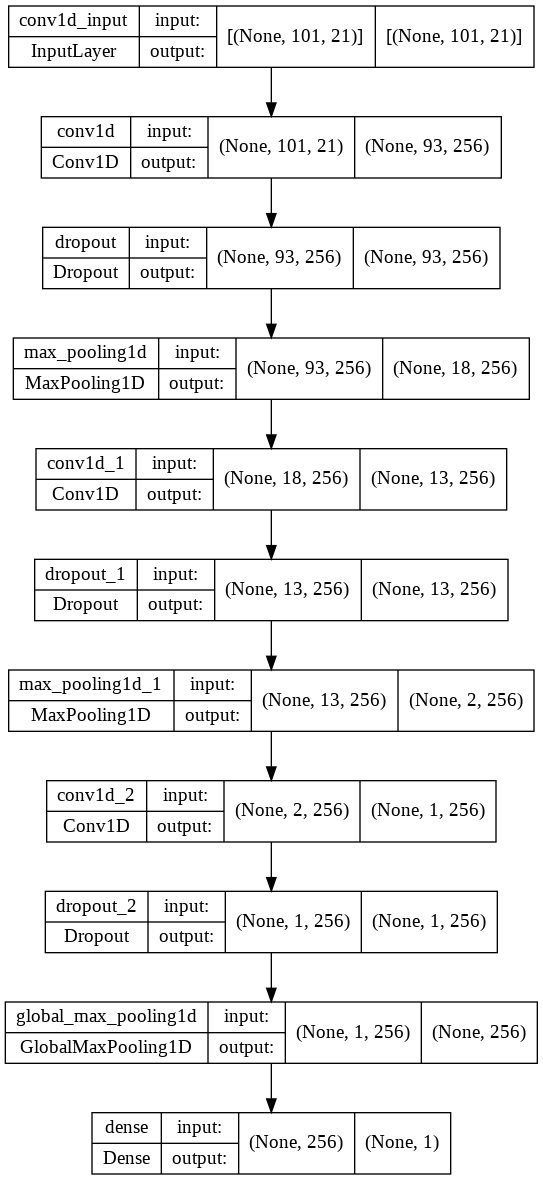

In [14]:
keras.utils.plot_model(model, show_shapes=True)

In [15]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [16]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=trace_level)

Epoch 1/40
1297/1297 [==============================] - ETA: 0s - loss: 0.4976 - binary_accuracy: 0.7624
Epoch 1: val_loss improved from inf to 0.49193, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_CNN_HYBRID_HsMm2.h5
1297/1297 [==============================] - 161s 114ms/step - loss: 0.4976 - binary_accuracy: 0.7624 - val_loss: 0.4919 - val_binary_accuracy: 0.7920
Epoch 2/40
1297/1297 [==============================] - ETA: 0s - loss: 0.4632 - binary_accuracy: 0.7881
Epoch 2: val_loss improved from 0.49193 to 0.44654, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_CNN_HYBRID_HsMm2.h5
1297/1297 [==============================] - 148s 114ms/step - loss: 0.4632 - binary_accuracy: 0.7881 - val_loss: 0.4465 - val_binary_accuracy: 0.8122
Epoch 3/40
1297/1297 [==============================] - ETA: 0s - loss: 0.4435 - binary_accuracy: 0.8043
Epoch 3: val_loss improved from 0.44654 to 0.42261, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_CNN_HYBR

In [17]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 19 of 40


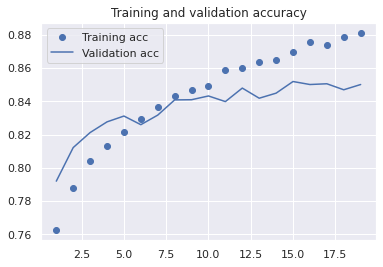

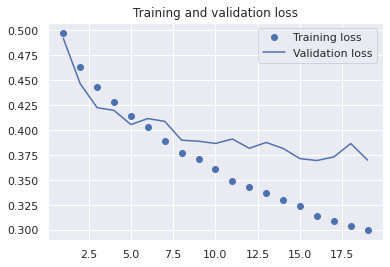

In [18]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [19]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [20]:
#EVALUATE VALIDATION DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=trace_level)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
277/277 [==============================] - 25s 91ms/step - loss: 0.3698 - binary_accuracy: 0.8501
Accuracy on validation data: 0.85
Loss on validation data: 0.37


We make predictions on test data, never used during training nor validation

In [21]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=trace_level)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
8895/8895 [==============================] - 44s 5ms/step


In [22]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(8895, 101)
(8895,)
(8895, 1)
(8895, 1)


In [23]:
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_CNN_HYBRID_HsMm2
---------------------------------
Kappa: 0.697
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4509
           1       0.90      0.77      0.83      4386

    accuracy                           0.85      8895
   macro avg       0.86      0.85      0.85      8895
weighted avg       0.86      0.85      0.85      8895



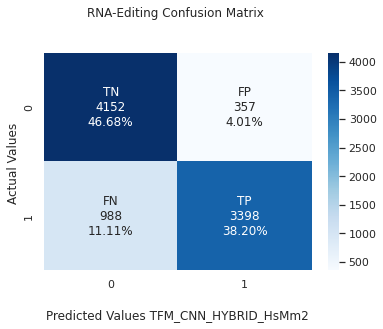

In [24]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
plt.show()


AUC: 0.91


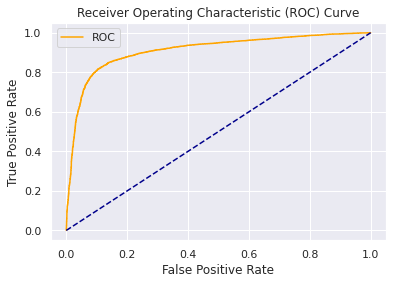

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)
